<a href="https://colab.research.google.com/github/Yasminebenhamadi/NMA/blob/main/CN/W1D4_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 2: Principal Component Analysis

**Week 1, Day 4: Dimensionality Reduction**

**By Neuromatch Academy**

__Content creators:__ Alex Cayco Gajic, John Murray

__Content reviewers:__ Roozbeh Farhoudi, Matt Krause, Spiros Chavlis, Richard Gao, Michael Waskom, Siddharth Suresh, Natalie Schaworonkow, Ella Batty


---
# Setup


In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# @title Figure Settings
import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [ ]:
# @title Plotting Functions

def plot_eigenvalues(evals):
  """
  Plots eigenvalues.

  Args:
      (numpy array of floats) : Vector of eigenvalues

  Returns:
    Nothing.

  """
  plt.figure(figsize=(4, 4))
  plt.plot(np.arange(1, len(evals) + 1), evals, 'o-k')
  plt.xlabel('Component')
  plt.ylabel('Eigenvalue')
  plt.title('Scree plot')
  plt.xticks(np.arange(1, len(evals) + 1))
  plt.ylim([0, 2.5])


def plot_data(X):
  """
  Plots bivariate data. Includes a plot of each random variable, and a scatter
  scatter plot of their joint activity. The title indicates the sample
  correlation calculated from the data.

  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable

  Returns:
    Nothing.
  """

  fig = plt.figure(figsize=[8, 4])
  gs = fig.add_gridspec(2, 2)
  ax1 = fig.add_subplot(gs[0, 0])
  ax1.plot(X[:, 0], color='k')
  plt.ylabel('Neuron 1')
  ax2 = fig.add_subplot(gs[1, 0])
  ax2.plot(X[:, 1], color='k')
  plt.xlabel('Sample Number (sorted)')
  plt.ylabel('Neuron 2')
  ax3 = fig.add_subplot(gs[:, 1])
  ax3.plot(X[:, 0], X[:, 1], '.', markerfacecolor=[.5, .5, .5],
           markeredgewidth=0)
  ax3.axis('equal')
  plt.xlabel('Neuron 1 activity')
  plt.ylabel('Neuron 2 activity')
  plt.title('Sample corr: {:.1f}'.format(np.corrcoef(X[:, 0], X[:, 1])[0, 1]))
  plt.show()


def plot_data_new_basis(Y):
  """
  Plots bivariate data after transformation to new bases. Similar to plot_data
  but with colors corresponding to projections onto basis 1 (red) and
  basis 2 (blue).
  The title indicates the sample correlation calculated from the data.

  Note that samples are re-sorted in ascending order for the first random
  variable.

  Args:
    Y (numpy array of floats) : Data matrix in new basis each column
                                corresponds to a different random variable

  Returns:
    Nothing.
  """

  fig = plt.figure(figsize=[8, 4])
  gs = fig.add_gridspec(2, 2)
  ax1 = fig.add_subplot(gs[0, 0])
  ax1.plot(Y[:, 0], 'r')
  plt.ylabel('Projection \n basis vector 1')
  ax2 = fig.add_subplot(gs[1, 0])
  ax2.plot(Y[:, 1], 'b')
  plt.xlabel('Sample number')
  plt.ylabel('Projection \n basis vector 2')
  ax3 = fig.add_subplot(gs[:, 1])
  ax3.plot(Y[:, 0], Y[:, 1], '.', color=[.5, .5, .5])
  ax3.axis('equal')
  plt.xlabel('Projection basis vector 1')
  plt.ylabel('Projection basis vector 2')
  plt.title('Sample corr: {:.1f}'.format(np.corrcoef(Y[:, 0], Y[:, 1])[0, 1]))
  plt.show()


def plot_basis_vectors(X, W):
  """
  Plots bivariate data as well as new basis vectors.

  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable
    W (numpy array of floats) : Square matrix representing new orthonormal
                                basis each column represents a basis vector

  Returns:
    Nothing.
  """

  plt.figure(figsize=[4, 4])
  plt.plot(X[:, 0], X[:, 1], '.', color=[.5, .5, .5], label='Data')
  plt.axis('equal')
  plt.xlabel('Neuron 1 activity')
  plt.ylabel('Neuron 2 activity')
  plt.plot([0, W[0, 0]], [0, W[1, 0]], color='r', linewidth=3,
           label='Basis vector 1')
  plt.plot([0, W[0, 1]], [0, W[1, 1]], color='b', linewidth=3,
           label='Basis vector 2')
  plt.legend()
  plt.show()

In [ ]:
# @title Helper functions

def sort_evals_descending(evals, evectors):
  """
  Sorts eigenvalues and eigenvectors in decreasing order. Also aligns first two
  eigenvectors to be in first two quadrants (if 2D).

  Args:
    evals (numpy array of floats)    : Vector of eigenvalues
    evectors (numpy array of floats) : Corresponding matrix of eigenvectors
                                        each column corresponds to a different
                                        eigenvalue

  Returns:
    (numpy array of floats)          : Vector of eigenvalues after sorting
    (numpy array of floats)          : Matrix of eigenvectors after sorting
  """

  index = np.flip(np.argsort(evals))
  evals = evals[index]
  evectors = evectors[:, index]
  if evals.shape[0] == 2:
    if np.arccos(np.matmul(evectors[:, 0],
                           1 / np.sqrt(2) * np.array([1, 1]))) > np.pi / 2:
      evectors[:, 0] = -evectors[:, 0]
    if np.arccos(np.matmul(evectors[:, 1],
                           1 / np.sqrt(2) * np.array([-1, 1]))) > np.pi / 2:
      evectors[:, 1] = -evectors[:, 1]
  return evals, evectors


def get_data(cov_matrix):
  """
  Returns a matrix of 1000 samples from a bivariate, zero-mean Gaussian

  Note that samples are sorted in ascending order for the first random
  variable.

  Args:
    var_1 (scalar)                     : variance of the first random variable
    var_2 (scalar)                     : variance of the second random variable
    cov_matrix (numpy array of floats) : desired covariance matrix

  Returns:
    (numpy array of floats)            : samples from the bivariate Gaussian,
                                          with each column corresponding to a
                                          different random variable
  """

  mean = np.array([0, 0])
  X = np.random.multivariate_normal(mean, cov_matrix, size=1000)
  indices_for_sorting = np.argsort(X[:, 0])
  X = X[indices_for_sorting, :]
  return X


def calculate_cov_matrix(var_1, var_2, corr_coef):
  """
  Calculates the covariance matrix based on the variances and
  correlation coefficient.

  Args:
    var_1 (scalar)         :  variance of the first random variable
    var_2 (scalar)         :  variance of the second random variable
    corr_coef (scalar)     :  correlation coefficient

  Returns:
    (numpy array of floats) : covariance matrix
  """
  cov = corr_coef * np.sqrt(var_1 * var_2)
  cov_matrix = np.array([[var_1, cov], [cov, var_2]])
  return cov_matrix


def define_orthonormal_basis(u):
  """
  Calculates an orthonormal basis given an arbitrary vector u.

  Args:
    u (numpy array of floats) : arbitrary 2D vector used for new basis

  Returns:
    (numpy array of floats)   : new orthonormal basis columns correspond to
                                basis vectors
  """

  u = u / np.sqrt(u[0] ** 2 + u[1] ** 2)
  w = np.array([-u[1], u[0]])
  W = np.column_stack((u, w))
  return W


def change_of_basis(X, W):
  """
  Projects data onto a new basis.

  Args:
    X (numpy array of floats) : Data matrix each column corresponding to a
                                different random variable
    W (numpy array of floats) : new orthonormal basis columns correspond to
                                basis vectors

  Returns:
    (numpy array of floats)   : Data matrix expressed in new basis
  """

  Y = np.matmul(X, W)
  return Y

In [ ]:
help(get_data)
help(calculate_cov_matrix)

In [ ]:
def get_sample_cov_matrix(X):
  """
  Returns the sample covariance matrix of data X

  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable

  Returns:
    (numpy array of floats)   : Covariance matrix
  """
  # Subtract the mean of X
  X = X - np.mean(X,0)

  # Calculate the covariance matrix (hint: use np.matmul)
  cov_matrix = 1/len(X)*X.T@X

  return cov_matrix


# Set parameters
np.random.seed(2020)  # set random seed
variance_1 = 1
variance_2 = 1
corr_coef = 0.8

# Calculate covariance matrix
cov_matrix = calculate_cov_matrix(variance_1, variance_2, corr_coef)
print(cov_matrix)

# Generate data with that covariance matrix
X = get_data(cov_matrix)

# Get sample covariance matrix
sample_cov_matrix = get_sample_cov_matrix(X)
print(sample_cov_matrix)

[[1.  0.8]
 [0.8 1. ]]
[[0.99315313 0.82347589]
 [0.82347589 1.01281397]]


In [ ]:
help(sort_evals_descending)

Help on function sort_evals_descending in module __main__:

sort_evals_descending(evals, evectors)
    Sorts eigenvalues and eigenvectors in decreasing order. Also aligns first two
    eigenvectors to be in first two quadrants (if 2D).
    
    Args:
      evals (numpy array of floats)    : Vector of eigenvalues
      evectors (numpy array of floats) : Corresponding matrix of eigenvectors
                                          each column corresponds to a different
                                          eigenvalue
    
    Returns:
      (numpy array of floats)          : Vector of eigenvalues after sorting
      (numpy array of floats)          : Matrix of eigenvectors after sorting



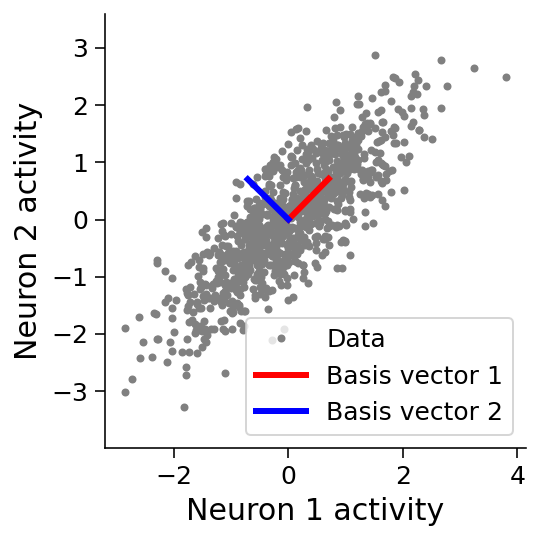

In [ ]:
# Calculate the eigenvalues and eigenvectors
evals, evectors = np.linalg.eigh(sample_cov_matrix)

# Sort the eigenvalues in descending order
evals, evectors = sort_evals_descending(evals,evectors)

# Visualize
plot_basis_vectors(X, evectors)

---
# Section 2: Perform PCA by projecting data onto the eigenvectors

*Estimated timing to here from start of tutorial: 25 min*


In [ ]:
help(change_of_basis)

Help on function change_of_basis in module __main__:

change_of_basis(X, W)
    Projects data onto a new basis.
    
    Args:
      X (numpy array of floats) : Data matrix each column corresponding to a
                                  different random variable
      W (numpy array of floats) : new orthonormal basis columns correspond to
                                  basis vectors
    
    Returns:
      (numpy array of floats)   : Data matrix expressed in new basis



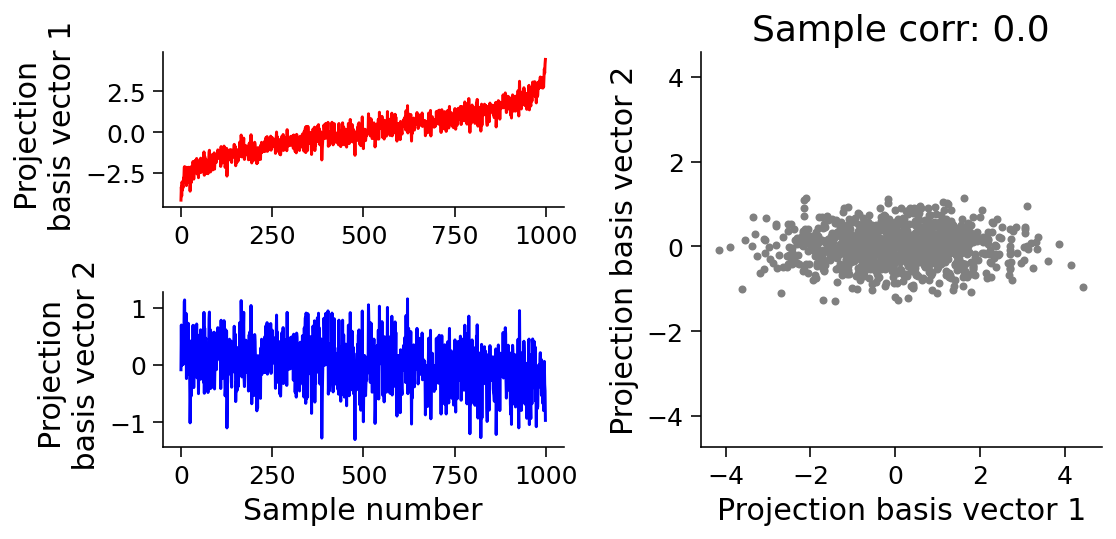

In [ ]:
def pca(X):
  """
  Sorts eigenvalues and eigenvectors in decreasing order.

  Args:
    X (numpy array of floats): Data matrix each column corresponds to a
                               different random variable

  Returns:
    (numpy array of floats)  : Data projected onto the new basis
    (numpy array of floats)  : Vector of eigenvalues
    (numpy array of floats)  : Corresponding matrix of eigenvectors

  """
  # Calculate the sample covariance matrix
  cov_matrix = get_sample_cov_matrix(X)

  # Calculate the eigenvalues and eigenvectors
  evals, evectors = np.linalg.eigh(sample_cov_matrix)

  # Sort the eigenvalues in descending order
  evals, evectors = sort_evals_descending(evals,evectors)

  # Project the data onto the new eigenvector basis
  score = X@evectors

  return score, evectors, evals


# Perform PCA on the data matrix X
score, evectors, evals = pca(X)

# Plot the data projected into the new basis
plot_data_new_basis(score)

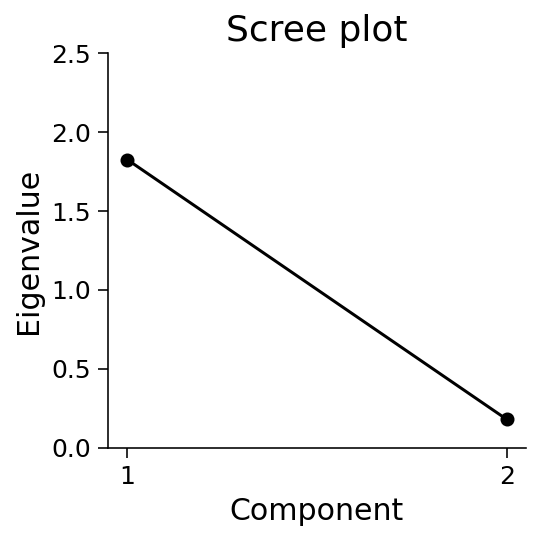

In [ ]:
plot_eigenvalues(evals)

In [ ]:
# @markdown Make sure you execute this cell to enable the widget!

def refresh(corr_coef=.8):
  cov_matrix = calculate_cov_matrix(variance_1, variance_2, corr_coef)
  X = get_data(cov_matrix)
  score, evectors, evals = pca(X)
  plot_eigenvalues(evals)
  plot_basis_vectors(X, evectors)


_ = widgets.interact(refresh, corr_coef=(-1, 1, .1))

interactive(children=(FloatSlider(value=0.8, description='corr_coef', max=1.0, min=-1.0), Output()), _dom_clas…